In [1]:
import os
# When using on Juypter Notebook, uncomment the code below
# import sys
# path = os.path.join(os.path.dirname(os.getcwd()))
# sys.path.append(path) 
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output as clear
from models.CNNTransformer import CNNTransformer
from trainTest.datasets.common_dataset_utils import get_file_name, get_save_path
from trainTest.datasets.intra_dl_dataset_utils import get_dl_datasets, get_dl_dataloaders
from trainTest.intra_train_test.train_test_dl_models import train_test_dl_models
from utils.common_utils import calculate_and_save_metrics, printlog
from utils.common_params import *

In [2]:
# 1. Parameter settings
subjects_list_global = list(['01', '02', '03', '04', '05', '31', '32', '33', '34', '35'])
total_exp_time = K_of_repeated_experiments if partitioning_method == 'repeated_experiments' else K_of_cross_validation 
settings = {'total_exp_time': total_exp_time}
# 2. Comparison of different denoising methods
emg_denoise_methods = ['rawdata', 'WD-GT','WPD-GT', 'EMD-PE-GT', 'EMD-PE-SVD', 'ICEEMDAN-PE-GT', 'ICEEMDAN-PE-SVD']

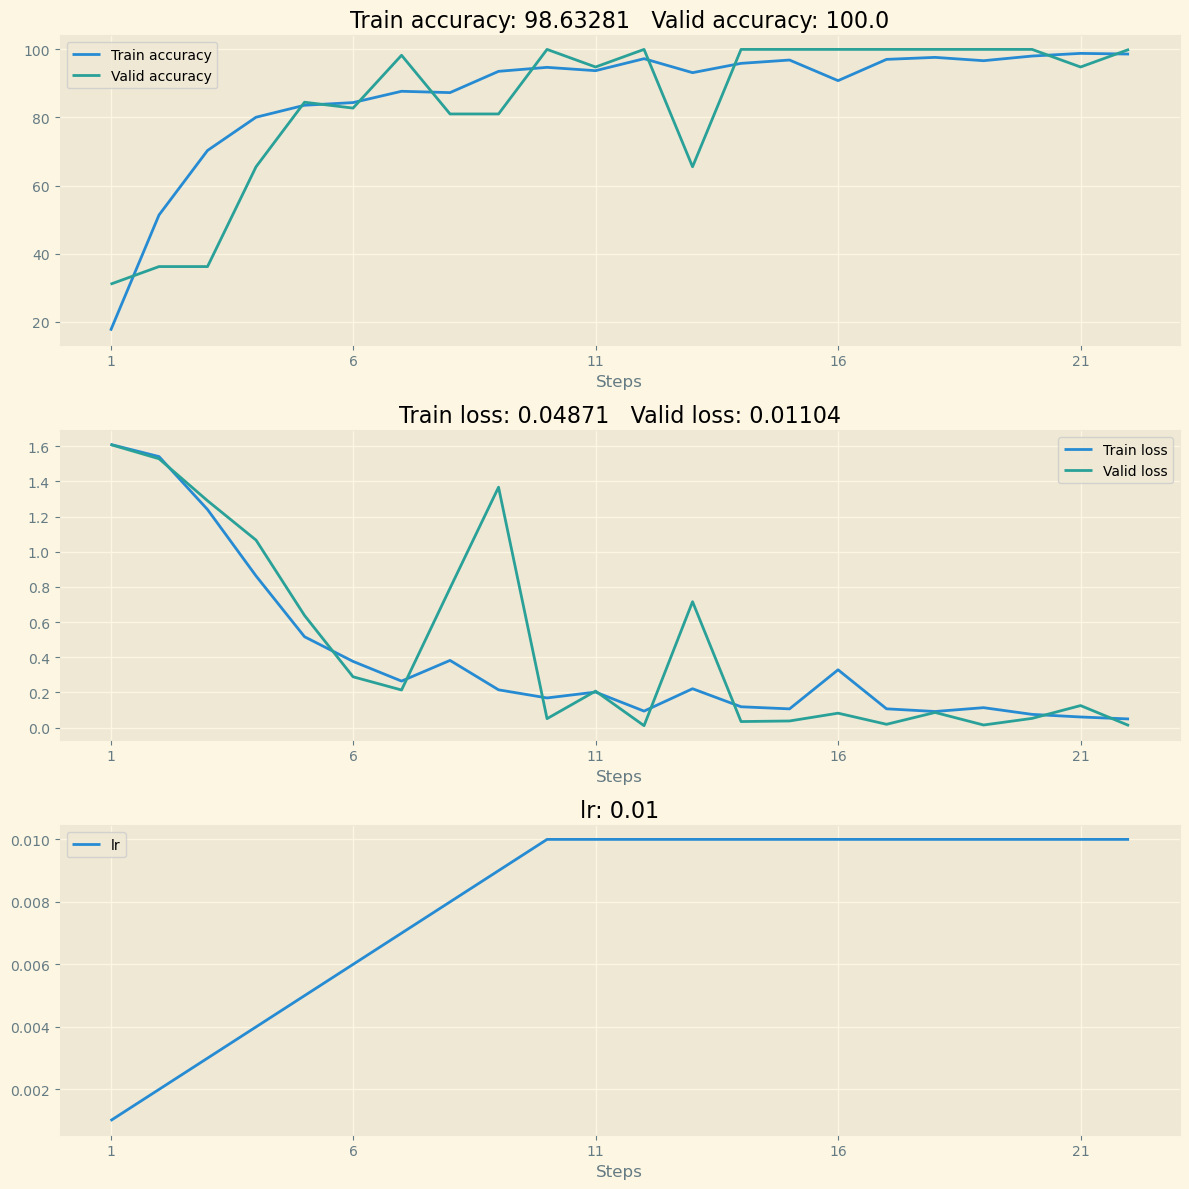

Step 22: train_acc: 98.63281  valid_acc: 100.0  train_loss: 0.04871  valid_loss: 0.01104  lr: 0.01  
EarlyStopping counter: 10 out of 10
Early stopping, save the model: 
Save the model training process: 
Test results: 
accuracy:  100.0.
precision:  100.0.
recall:  100.0.
f1:  100.0.
specificity:  100.0.
npv:  100.0.
Calculate confusion matrix: 
Confusion Matrix: 
[[28  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  0 42  0]
 [ 0  0  0  0 52]]
Normalized Confusion Matrix: 
[[100.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.]
 [  0.   0. 100.   0.   0.]
 [  0.   0.   0. 100.   0.]
 [  0.   0.   0.   0. 100.]]


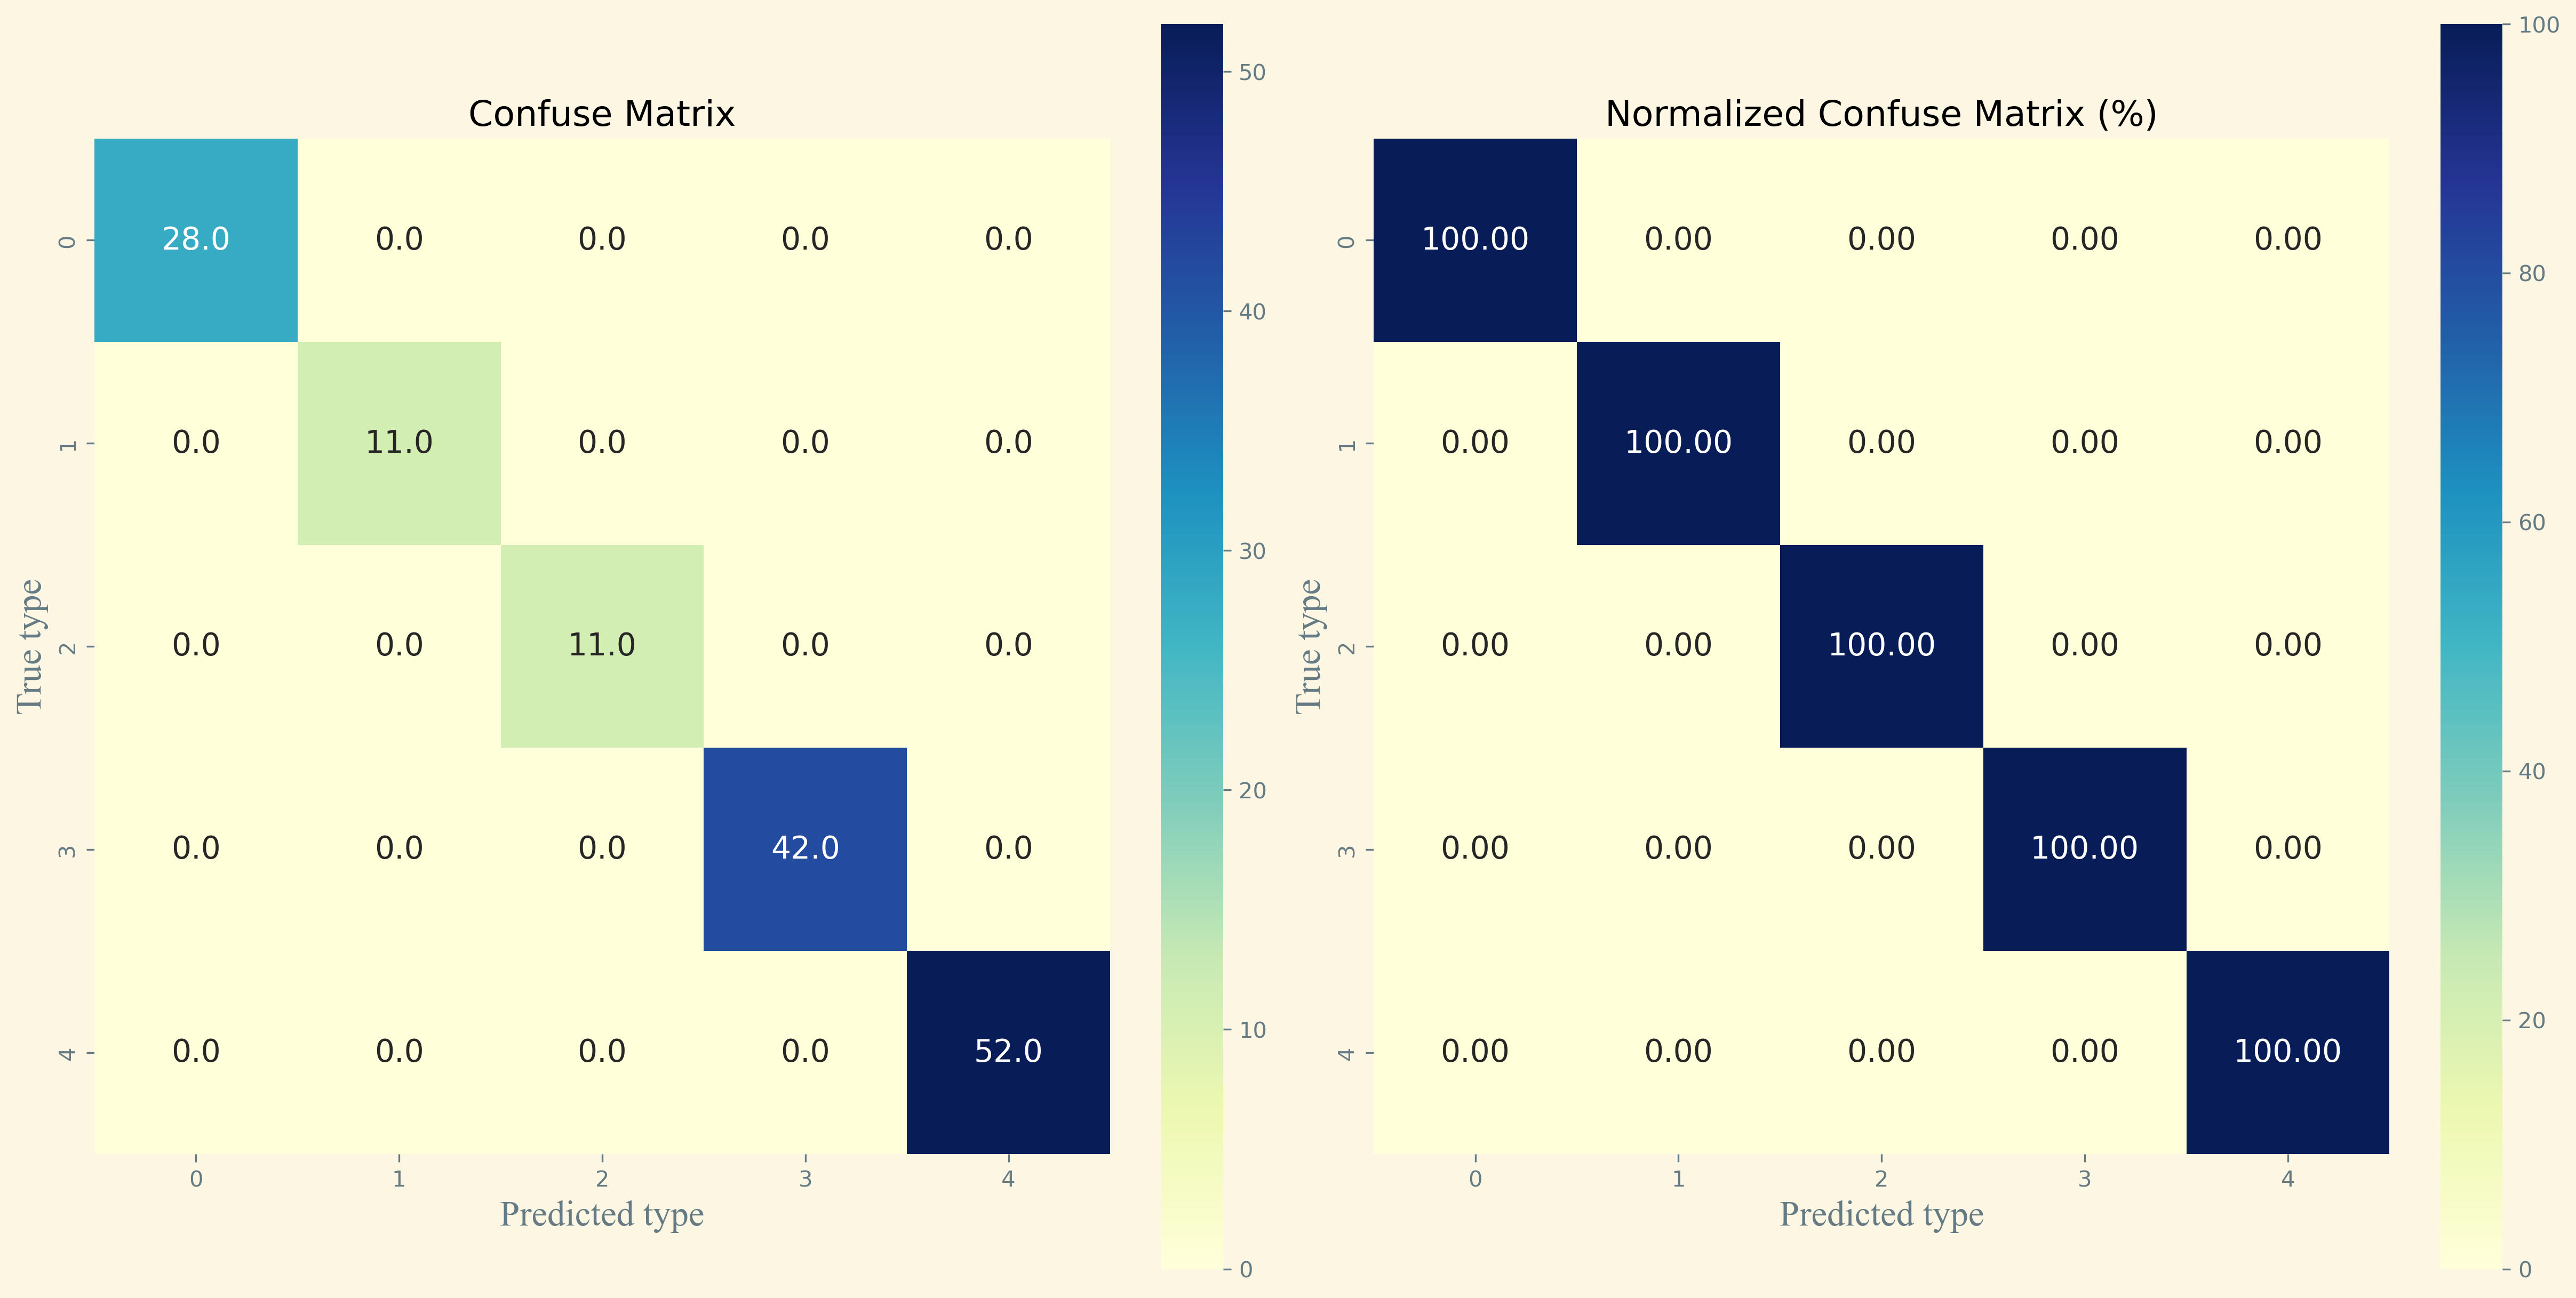

Saving the average results of all tested metrics for all subjects...
Saving the averaged results of the individual subject test metrics averaged...
All results saved!


In [3]:
for emg_denoise_method in emg_denoise_methods:
    file_path = os.path.join(os.path.dirname(os.getcwd()) , 'preProcessing', 'SIAT_LLMD_trainData', emg_denoise_method)
    basic_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'Intra_Deep_Learning', emg_denoise_method)
    model = CNNTransformer()
    model_name = model.get_model_name()
    
    for subject_order in range(len(subjects_list_global)):
        subject = subjects_list_global[subject_order]
        file_name = get_file_name(file_path, subject, subjects_list_global)
        save_path = get_save_path(basic_save_path, model_name, subject)
        settings['save_path'] = save_path
        all_x_train, all_y_train, all_x_valid, all_y_valid, all_x_test, all_y_test = get_dl_datasets(file_name, data_name='sub_emg_sample', label_name='sub_motion_label_encoded')
        
        for exp_tim in range(total_exp_time):
            clear()
            x_train, y_train, x_valid, y_valid, x_test, y_test = all_x_train[exp_tim], all_y_train[exp_tim], all_x_valid[exp_tim], all_y_valid[exp_tim], all_x_test[exp_tim], all_y_test[exp_tim]
            train_loader, valid_loader, test_loader = get_dl_dataloaders(x_train, y_train, x_valid, y_valid, x_test, y_test)
            current_exp_time = exp_tim + 1
            settings['current_exp_time'] = current_exp_time

            printlog(info='Denoising method: %s, model: %s'% (emg_denoise_method, model_name), time=True, line_break=False)
            printlog(info='Subject: %s' % subject, time=True, line_break=False)
            printlog(info='Number of trails: %d / %d' % (current_exp_time, total_exp_time), time=True, line_break=False)
            print('dataset_partitioning_method: ', partitioning_method)
            print('x_train.shape: ', x_train.shape, ', y_train.shape: ', y_train.shape)
            print('x_valid.shape: ', x_valid.shape, ', y_valid.shape: ', y_valid.shape)
            print('x_test.shape: ', x_test.shape, ', y_test.shape: ', y_test.shape)
            print('Sample size of train set, valid set and test set are: ', len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset))
            
            model = CNNTransformer()
            model.double()
            model.to(device=device)
            train_test_dl_models(settings, model, train_loader, valid_loader, test_loader)
                
    path = os.path.join(basic_save_path, model_name)
    calculate_and_save_metrics(path, subjects_list_global) 